## Homework 2.2
### Optimization, variant 3
#### Sofiia Petryshyn, APPS UCU

## Gross profit maximisation

In [635]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.optimize import rosen_der

np.random.seed(1729)
plt.rcParams['figure.figsize'] = 15, 8

Text(0.5, 1.0, 'Goal to sell the amount of tonnes during the year')

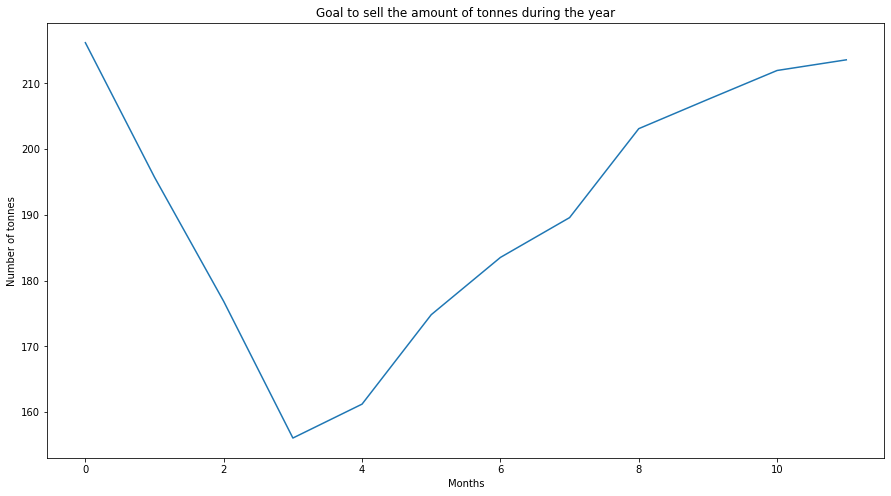

In [611]:
# Production
goal = np.array([216.18616928, 195.718539, 176.8435644, 156.06823893, 161.2252143,\
 174.82359282, 183.53185311, 189.58580472, 203.11211409, 207.56262067,
 211.95970354, 213.57970776])
plt.plot(goal, label='goal')
plt.xlabel('Months')
plt.ylabel('Number of tonnes')
plt.title('Goal to sell the amount of tonnes during the year')

In [612]:
# Prices limits
b = (85.0,135.)
bnds = [b for _ in range(w)]
bnds

[(85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0),
 (85.0, 135.0)]

### Our demand

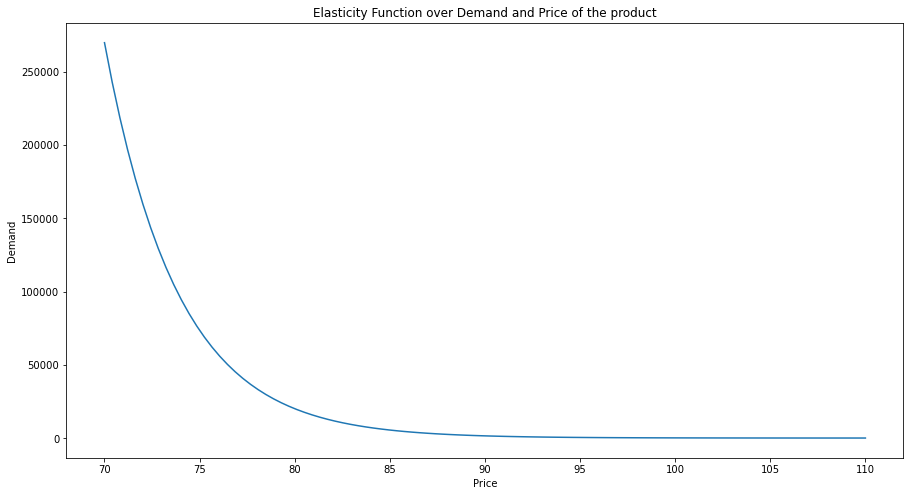

In [613]:
a = min(goal) #min forecast
b = max(goal) #max forecast

def elasticity_func(x):
    # return demand
    return b * np.exp(-0.26 * x) * 1e11 + a

pricing_level = np.linspace(70, 110, 100)
plt.plot(pricing_level, elasticity_func(pricing_level))
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Elasticity Function over Demand and Price of the product');

### Our price per saving

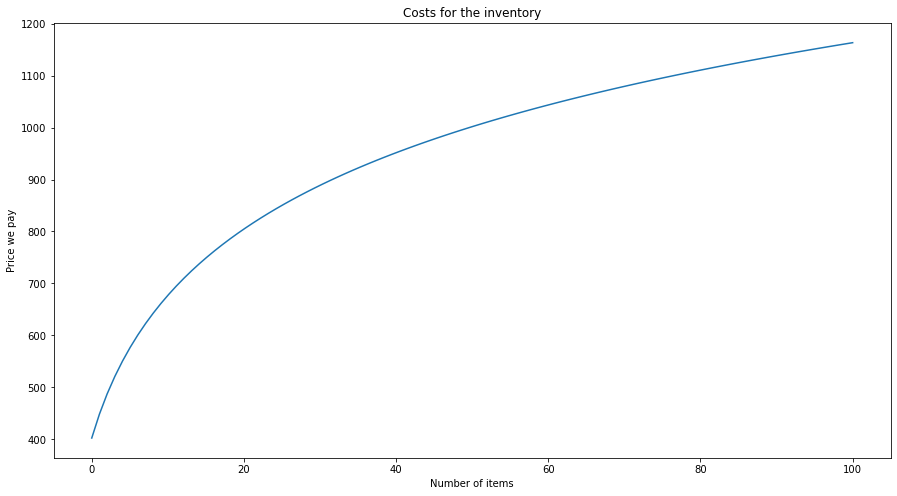

In [618]:
def inventory(x):
    a = 0.2
    return 250 * np.log(x + 5)

inv_level = np.linspace(0, 100, 100)
plt.plot(inv_level, inventory(inv_level))
plt.title('Costs for the inventory')
plt.xlabel('Number of items')
plt.ylabel('Price we pay');

In [619]:
# Inventory (how many items we can store) limit 1800 items
# x = price
def constraint(x):
    total_items = 1800.
    return total_items - sum([elasticity_func(i) for i in x])

con = {'type': 'ineq', 'fun': constraint}

In [620]:
from scipy.optimize import BFGS
from scipy.optimize import NonlinearConstraint

def cons_f(x):
    return [elasticity_func(xx) - goal[i] + margin for i, xx in enumerate(x)]


nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac='cs', hess=BFGS())

In [621]:
def costs(i, price):
    demand = elasticity_func(np.array(price)) # demand on price = price
    num_of_items_in_inventory = goal[i] - demand
    if num_of_items_in_inventory < 0:
        num_of_items_in_inventory = 0
    inv_costs = inventory(num_of_items_in_inventory)
    return inv_costs

In [623]:
# Optimization problem 
# Revenue = sum(Price * Sales)

# Let's take 12 months 
w = 12

# Optimization function is:
def revenue(ind, p):
    a = p*elasticity_func(p) - costs(ind, p)
    return a

def obj(x):
    return -sum([revenue(ind, xx) for ind, xx in enumerate(x)])

# Sales function
def sales_function(x):
    return sum([elasticity_func(i) for i in x])

In [624]:
from scipy.optimize import rosen, rosen_der, rosen_hess, rosen_hess_prod
# initial approximation
x0 = 111. * np.ones(w)

### SLSQP with Jacobian of Rosen Der & Linear and Non-linear constraint

In [625]:
cons = ([con, nonlinear_constraint])
# Find solution
solution = minimize(obj, x0, method='SLSQP',\
                    jac=rosen_der,
                    bounds=bnds, constraints=cons,\
                    options={'maxiter': 1000, 'ftol': 1e-06, 'iprint': 1,\
                            'disp': True, 'eps': 1.4901161193847656e-08})

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -206491.81944440305
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1


In [626]:
x = solution.x

# show final objective
print('Final Objective (Revenue): ' + str(-obj(x)))

# show initial sales
print('Final Sales: ' + str(sales_function(x)))

Final Objective (Revenue): 206491.81944440305
Final Sales: 1948.7238706226915


In [627]:
x

array([111., 111., 111., 111., 111., 111., 111., 111., 111., 111., 111.,
       111.])

### SLSQP without Jacobian

In [628]:
cons = ([con, nonlinear_constraint])
# Find solution
solution = minimize(obj, x0, method='SLSQP',\
                    bounds=bnds, constraints=cons,\
                    options={'maxiter': 1000, 'ftol': 1e-06, 'iprint': 1,\
                            'disp': True, 'eps': 1.4901161193847656e-08})

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -239112.8402821657
            Iterations: 14
            Function evaluations: 180
            Gradient evaluations: 10


In [629]:
x = solution.x

# show final objective
print('Final Objective (Revenue): ' + str(-obj(x)))

# show initial sales
print('Final Sales: ' + str(sales_function(x)))

Final Objective (Revenue): 239112.8402821657
Final Sales: 1920.2214501708102


In [630]:
x

array([135.        , 135.        , 106.71901577, 135.        ,
       135.        , 105.27465553, 135.        , 135.        ,
       135.        , 135.        , 135.        , 135.        ])

### SLSQP with Three Linear Constrains

In [631]:
margin = 3.

def constraint2(x):
    return sum(np.ceil([elasticity_func(xx) - goal[i] + margin for i, xx in enumerate(x)]))
               
con2 = {'type': 'ineq', 'fun': constraint2}

def constraint3(x):
    return sum(np.ceil([-elasticity_func(xx) + (goal[i] + margin) for i, xx in enumerate(x)]))

con3 = {'type': 'ineq', 'fun': constraint3}

In [632]:
cons = ([con, con2, con3])
# Find solution
solution = minimize(obj, x0, method='SLSQP',\
                    bounds=bnds, constraints=cons,\
                    options={'maxiter': 1000, 'ftol': 1e-06, 'iprint': 1,\
                            'disp': True, 'eps': 1.4901161193847656e-08})

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -309908.7542981285
            Iterations: 12
            Function evaluations: 109
            Gradient evaluations: 8


In [633]:
x = solution.x

# show final objective
print('Final Objective (Revenue): ' + str(-obj(x)))

# show initial sales
print('Final Sales: ' + str(sales_function(x)))

Final Objective (Revenue): 309908.7542981285
Final Sales: 2706.9985969552736


In [634]:
x

array([134.99999578, 134.99999577, 134.99999573, 134.99999578,
       134.99999579,  94.8886356 ,  94.89153508, 134.99999577,
       134.99999578, 134.99999577, 134.99999577, 134.99999577])

#### Conclusions:
We did three different ways to construct the prediction of the most optimal prices.\
##### Constrains:
1. On the inventory that we can store
2. On the demand that we want to be the one that follows the forecast
It turned out that the best `Revenue = 309908.7542981285` and the most items are sold we get from method of minimisation `SLSQR`, where we set 3 linear constrains with a particular margin for two of them that works for demand.\
In this case we just set the maximum prices everywhere, just not in the cases of the lowest demand during the year.\

Other thechnic is `SLSQR`, `Revenue = 239112.8402821657`, sales are lower. Here we use Non-linear constrain for the demand and we can observe two months to be about of the average.\

Next technic is to use `SLSQR` with the Jacobian being calculated by `Rosen Derivative`. This method always gives as an average, so we have the lowest Revenue and Sales.